## Score: 31

## Comment: 

<font color=Red>
Q1.[11] Good job!
<br><br>
Q2.[10+10] Correct
<br><br>
</font>

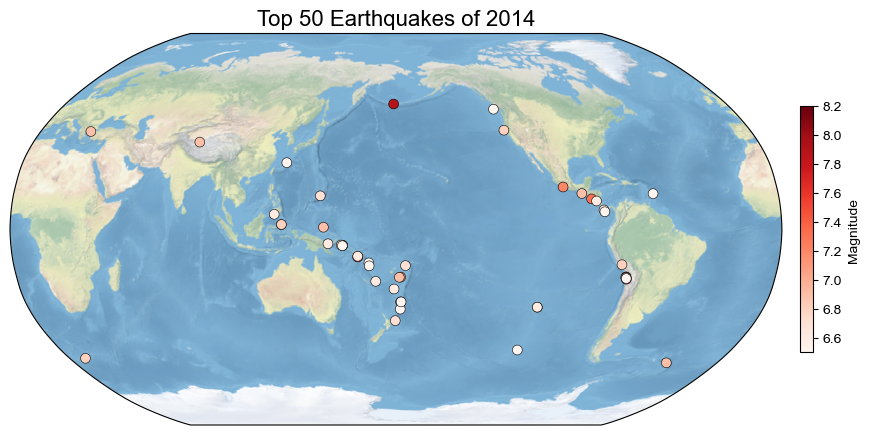

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# 1. 读取数据
df_earthquake = pd.read_csv(r"usgs_earthquakes.csv")

# 如果 time 是字符串，则转换日期类型
df_earthquake["time"] = pd.to_datetime(df_earthquake["time"], errors="coerce")

# 2. 筛选 2014 年地震
df_2014_eq = df_earthquake[df_earthquake["time"].dt.year == 2014]

# 3. 按震级选取前 50 个
df_top50_eq = df_2014_eq.nlargest(50, "mag")

# 4. 绘制地图
plt.figure(figsize=(12, 8))

# 设置字体为 Arial
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.unicode_minus'] = False

# 使用 Robinson 投影，设置中心经度为太平洋中心 (180°)
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))

# 设置地图范围
ax.set_global()

# 加载内置的底图
ax.stock_img()

# 去掉地图的边界、海岸线和其他元素
ax.set_facecolor("white")
ax.gridlines(linewidth=0)
ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='white')

# 5. 绘制地震散点图
scatter_plot = plt.scatter(
    df_top50_eq["longitude"],
    df_top50_eq["latitude"],
    c=df_top50_eq["mag"],
    s=50,
    cmap="Reds",
    edgecolor="black",
    linewidth=0.4,
    transform=ccrs.PlateCarree()
)

# 6. 添加颜色条，调整尺寸
color_bar = plt.colorbar(scatter_plot, shrink=0.4, pad=0.02)

# 设置颜色条的刻度范围从6.6到8.2，间隔为0.2
min_magnitude = 6.6
max_magnitude = 8.2
tick_values = np.arange(min_magnitude, max_magnitude + 0.01, 0.2)

# 设置颜色条的刻度
color_bar.set_ticks(tick_values)
color_bar.set_ticklabels([f'{tick:.1f}' for tick in tick_values])
color_bar.set_label("Magnitude", fontname='Arial')

# 7. 添加标题
plt.title("Top 50 Earthquakes of 2014", fontsize=16, fontname='Arial')

# 8. 显示地图
plt.show()

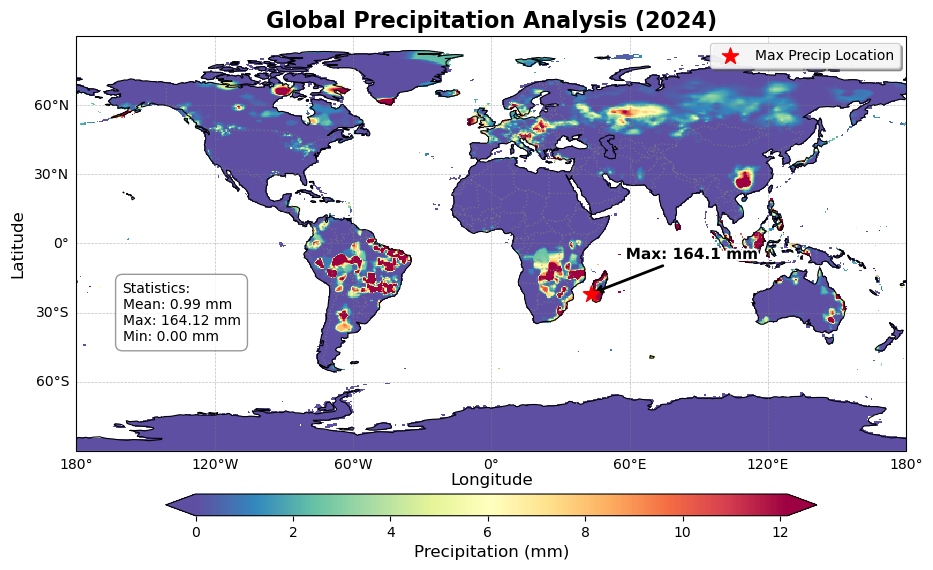

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# ==========================================
# 0. 全局设置：字体设为 Arial
# ==========================================
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
# 注意：如果这行代码后中文无法显示，那是正常的，因为Arial不支持中文
# 但你的图全是英文，所以没问题。

# ==========================================
# 1. 准备数据
# ==========================================
try:
    ds = xr.open_dataset('precip.2024.nc')
    data = ds['precip'].isel(time=0)
except FileNotFoundError:
    # 模拟数据
    lon = np.linspace(0, 359, 360)
    lat = np.linspace(-90, 90, 180)
    precip_data = np.zeros((180, 360))
    X, Y = np.meshgrid(lon, lat)
    precip_data = 10 * np.exp(-((Y-0)**2)/400) * (np.sin(X/20)**2) + np.random.rand(180, 360) * 2
    data = xr.DataArray(precip_data, coords={'lat': lat, 'lon': lon}, dims=('lat', 'lon'))

def plot_final_arial():
    fig = plt.figure(figsize=(12, 7))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

    # 2. 绘制填色图
    mesh = data.plot(ax=ax, transform=ccrs.PlateCarree(), 
                     cmap='Spectral_r', robust=True, add_colorbar=False)

    # 3. 地图特征
    ax.coastlines(resolution='110m', color='black', linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray', alpha=0.6)

    # 4. 网格线
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, linestyle='--', color='gray', alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 11}
    gl.ylabel_style = {'size': 11}

    # 5. 轴标签 (Arial字体)
    ax.text(0.5, -0.08, 'Longitude', transform=ax.transAxes, ha='center', fontsize=12)
    ax.text(-0.08, 0.5, 'Latitude', transform=ax.transAxes, va='center', rotation='vertical', fontsize=12)

    # 6. 标题 (Arial Bold)
    ax.set_title('Global Precipitation Analysis (2024)', fontsize=16, fontweight='bold')

    # --- 数据处理：找最大值 ---
    max_val = data.max().values
    max_loc = data.where(data == max_val, drop=True)
    # 确保取出来是标量
    mx_lat = float(max_loc['lat'].values.flat[0])
    mx_lon = float(max_loc['lon'].values.flat[0])

    # 7. 绘制最大值点 (红色星星)
    ax.scatter(mx_lon, mx_lat, color='red', marker='*', s=180, 
               transform=ccrs.PlateCarree(), zorder=10)

    # 8. [Annotation 标注] 指向星星的箭头
    ax.annotate(f'Max: {max_val:.1f} mm', 
                xy=(mx_lon, mx_lat), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax),
                xytext=(mx_lon + 15, mx_lat + 15), textcoords=ccrs.PlateCarree()._as_mpl_transform(ax),
                arrowprops=dict(facecolor='black', arrowstyle='->', lw=2),
                color='black', fontweight='bold', fontsize=11,
                path_effects=[pe.withStroke(linewidth=3, foreground="white")])

    # 9. [Text Box 统计框 + 图例说明]
    # 【修改】：将特殊符号 ★ 改为普通星号 *，或者直接用文字 "Red Star"
    # Arial 字体肯定包含普通星号 *
    stats_text = (
                  f"Mean: {data.mean().values:.2f} mm\n"
                  f"Min:  {data.min().values:.2f} mm\n"
                  f"Max:  {max_val:.2f} mm\n"
                  f"(Location marked by *)") # 这里改成了键盘上的普通星号

    ax.text(-160, -30, stats_text, transform=ccrs.PlateCarree(), fontsize=11,
            verticalalignment='center', horizontalalignment='left',
            fontfamily='Arial', 
            bbox=dict(boxstyle='round,pad=0.6', facecolor='white', alpha=0.9, edgecolor='gray'))

    # 10. 色标
    cbar = plt.colorbar(mesh, ax=ax, orientation='horizontal', 
                        pad=0.08, shrink=0.7, aspect=30, extend='both')
    cbar.set_label('Precipitation (mm)', fontsize=12)
    cbar.ax.tick_params(labelsize=10)

    plt.show()

plot_final_arial()

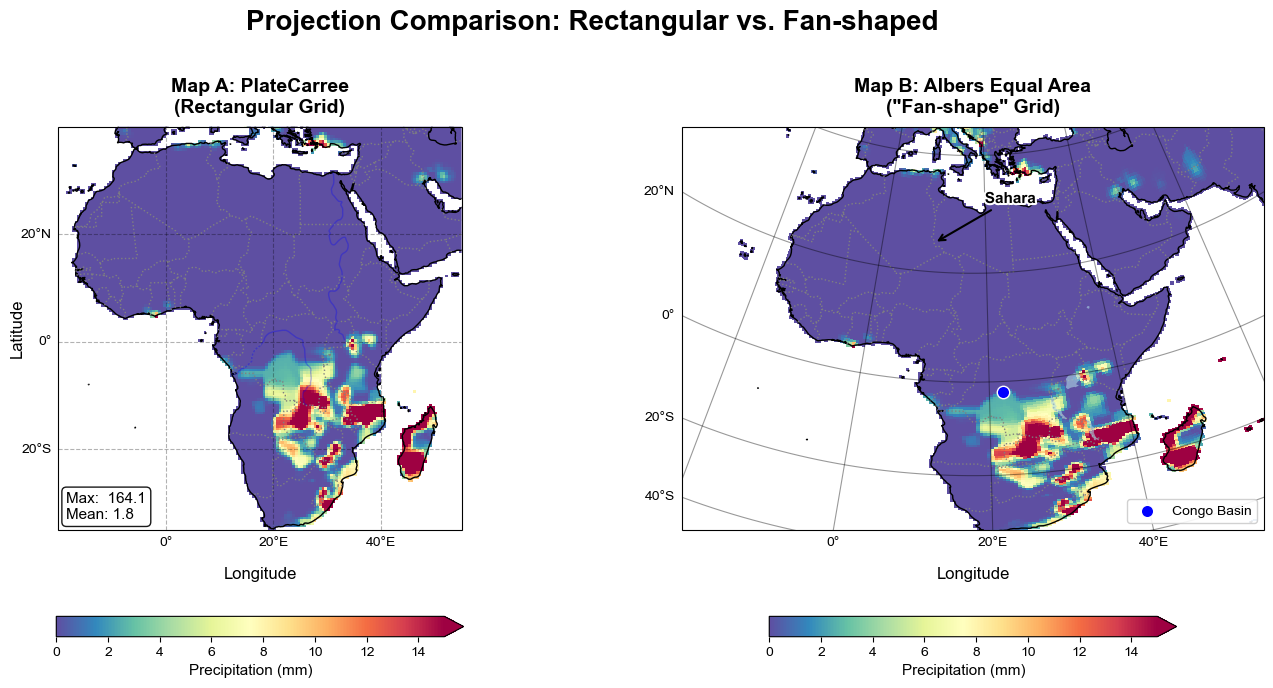

In [27]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker

# ==========================================
# 0. 全局设置
# ==========================================
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

# ==========================================
# 1. 准备数据
# ==========================================
view_extent = [-20, 55, -35, 40]

try:
    ds = xr.open_dataset('precip.2024.nc')
    data = ds['precip'].isel(time=0)
    
    # 绘图数据范围：切片纬度，保留经度以防白边
    data_plotting = data.sel(lat=slice(-60, 60))
    if data_plotting.size == 0:
         data_plotting = data.sel(lat=slice(60, -60))
         
    # 统计数据
    data_stats = data.sel(lat=slice(view_extent[2], view_extent[3]), 
                          lon=slice(view_extent[0], view_extent[1]))
    if data_stats.size == 0:
        data_stats = data.sel(lat=slice(view_extent[3], view_extent[2]), 
                              lon=slice(view_extent[0], view_extent[1]))

except FileNotFoundError:
    # 模拟数据
    lon = np.linspace(-180, 180, 360)
    lat = np.linspace(-90, 90, 180)
    X, Y = np.meshgrid(lon, lat)
    precip_data = 15 * np.exp(-((Y-0)**2 + (X-20)**2)/300) + np.random.rand(180, 360)
    data = xr.DataArray(precip_data, coords={'lat': lat, 'lon': lon}, dims=('lat', 'lon'))
    data_plotting = data.sel(lat=slice(-60, 60))
    data_stats = data.sel(lat=slice(-35, 40), lon=slice(-20, 55))

def plot_final_adjusted():
    fig = plt.figure(figsize=(16, 9))
    
    if data_stats.size > 0:
        max_val = data_stats.max().values
        mean_val = data_stats.mean().values
    else:
        max_val = np.nan
        mean_val = np.nan
    
    # 色带参数：保持较短(0.6)且有足够距离
    cbar_kwargs = {'orientation': 'horizontal', 'shrink': 0.6, 'pad': 0.15, 'extend': 'max'}

    # 预定义刻度位置
    xticks = np.arange(-20, 61, 20)
    yticks = np.arange(-40, 41, 20)

    # =======================================================
    # 左图: PlateCarree
    # =======================================================
    ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
    ax1.set_extent(view_extent, crs=ccrs.PlateCarree())
    
    mesh1 = data_plotting.plot(ax=ax1, transform=ccrs.PlateCarree(), 
                               cmap='Spectral_r', vmin=0, vmax=15, add_colorbar=False)
    
    ax1.coastlines(resolution='50m', color='black')
    ax1.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray', facecolor='none')
    ax1.add_feature(cfeature.RIVERS, edgecolor='blue', facecolor='none', alpha=0.3)
    
    # Gridlines
    gl1 = ax1.gridlines(draw_labels={'bottom': 'x', 'left': 'y', 'top': False, 'right': False}, 
                        linestyle='--', color='black', alpha=0.3)
    gl1.xlocator = mticker.FixedLocator(xticks)
    gl1.ylocator = mticker.FixedLocator(yticks)
    gl1.xlabel_style = {'size': 10}
    gl1.ylabel_style = {'size': 10}

    ax1.set_title('Map A: PlateCarree\n(Rectangular Grid)', fontsize=14, fontweight='bold', pad=10)
    
    # 【修改点1】将坐标从 (-0.05, 0.05) 改为 (0.02, 0.02)
    # 这样统计框就会乖乖呆在地图左下角内部，而不会超出地图
    stats_text = (f"Max:  {max_val:.1f}\nMean: {mean_val:.1f}")
    ax1.text(0.02, 0.02, stats_text, transform=ax1.transAxes, fontsize=11,
             verticalalignment='bottom', horizontalalignment='left',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    ax1.text(-0.12, 0.5, 'Latitude', transform=ax1.transAxes, rotation='vertical', va='center', fontsize=12)
    ax1.text(0.5, -0.12, 'Longitude', transform=ax1.transAxes, ha='center', fontsize=12)

    cbar1 = plt.colorbar(mesh1, ax=ax1, **cbar_kwargs)
    cbar1.set_label('Precipitation (mm)', fontsize=11)

    # =======================================================
    # 右图: Albers Equal Area
    # =======================================================
    proj_conic = ccrs.AlbersEqualArea(central_longitude=17.5, central_latitude=0)
    ax2 = fig.add_subplot(1, 2, 2, projection=proj_conic)
    ax2.set_extent(view_extent, crs=ccrs.PlateCarree())

    mesh2 = data_plotting.plot(ax=ax2, transform=ccrs.PlateCarree(), 
                               cmap='Spectral_r', vmin=0, vmax=15, add_colorbar=False)
    
    ax2.coastlines(resolution='50m', color='black')
    ax2.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray', facecolor='none')
    ax2.add_feature(cfeature.LAKES, facecolor='lightblue', edgecolor='none', alpha=0.6)
    
    # Gridlines
    gl2 = ax2.gridlines(draw_labels={'bottom': 'x', 'left': 'y', 'top': False, 'right': False}, 
                        linestyle='-', color='black', alpha=0.4, 
                        rotate_labels=False)
    gl2.xlocator = mticker.FixedLocator(xticks)
    gl2.ylocator = mticker.FixedLocator(yticks)
    gl2.xlabel_style = {'size': 10, 'color': 'black'}
    gl2.ylabel_style = {'size': 10, 'color': 'black'}

    ax2.set_title('Map B: Albers Equal Area\n("Fan-shape" Grid)', fontsize=14, fontweight='bold', pad=10)

    ax2.annotate('Sahara', 
                xy=(10, 25), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax2),
                xytext=(20, 32), textcoords=ccrs.PlateCarree()._as_mpl_transform(ax2),
                arrowprops=dict(facecolor='black', arrowstyle='->', lw=1.5),
                color='black', fontweight='bold', fontsize=11,
                path_effects=[pe.withStroke(linewidth=3, foreground="white")])

    ax2.scatter(22, -2, color='blue', marker='o', s=80, transform=ccrs.PlateCarree(), 
                label='Congo Basin', zorder=10, edgecolor='white')
    ax2.legend(loc='lower right', framealpha=0.9, fontsize=10)
    
    ax2.text(0.5, -0.12, 'Longitude', transform=ax2.transAxes, ha='center', fontsize=12)

    cbar2 = plt.colorbar(mesh2, ax=ax2, **cbar_kwargs)
    cbar2.set_label('Precipitation (mm)', fontsize=11)

    # =======================================================
    # 布局调整
    # =======================================================
    # 【修改点2】wspace 从 0.15 改为 0.05，拉近两图距离
    plt.subplots_adjust(top=0.82, bottom=0.18, wspace=0.05, left=0.08, right=0.95)
    plt.suptitle("Projection Comparison: Rectangular vs. Fan-shaped", fontsize=20, fontweight='bold', y=0.95)
    
    plt.show()

plot_final_adjusted()